<a href="https://colab.research.google.com/github/theboredman/CSE468/blob/main/Quiz_1/CNN/Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN (CIFAR 10 Dataset)

## Setup

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Prepare the data

In [2]:
num_classes = 10
input_shape = (3, 32, 32)  # PyTorch uses (channels, height, width)

# Define transforms for data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
# Set num_workers=0 for Windows compatibility
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=0)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")


Training samples: 50000
Test samples: 10000


## Configure the hyperparameters

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 50  # Increased for better training

# Additional hyperparameters
dropout_rate = 0.3
label_smoothing = 0.1
warmup_epochs = 5


## Use data augmentation

In [4]:
# Data augmentation is handled in the transforms defined earlier
# PyTorch transforms are applied during data loading
print("Data augmentation configured in the DataLoader transforms")

Data augmentation configured in the DataLoader transforms


## Implement multilayer perceptron (MLP)

In [5]:
# MLP helper class for PyTorch
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super(MLP, self).__init__()
        layers = []
        in_features = input_dim
        for units in hidden_units:
            layers.append(nn.Linear(in_features, units))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = units
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


## CNN Architecture

We'll build a CNN with convolutional layers for feature extraction followed by dense layers for classification.

In [6]:
# Improved CNN Architecture for CIFAR-10
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class CNNClassifier(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(CNNClassifier, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks - optimized architecture
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier head - simplified
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(512, num_classes)

        # Initialize weights
        self._initialize_weights()

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial conv
        out = torch.relu(self.bn1(self.conv1(x)))

        # Residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Global pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)

        # Classifier
        out = self.dropout(out)
        out = self.fc(out)
        return out


# Create model instance
model = CNNClassifier(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")


Model created with 11,173,962 parameters


## Compile, train, and evaluate the model


Model Architecture:
CNNClassifier(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64

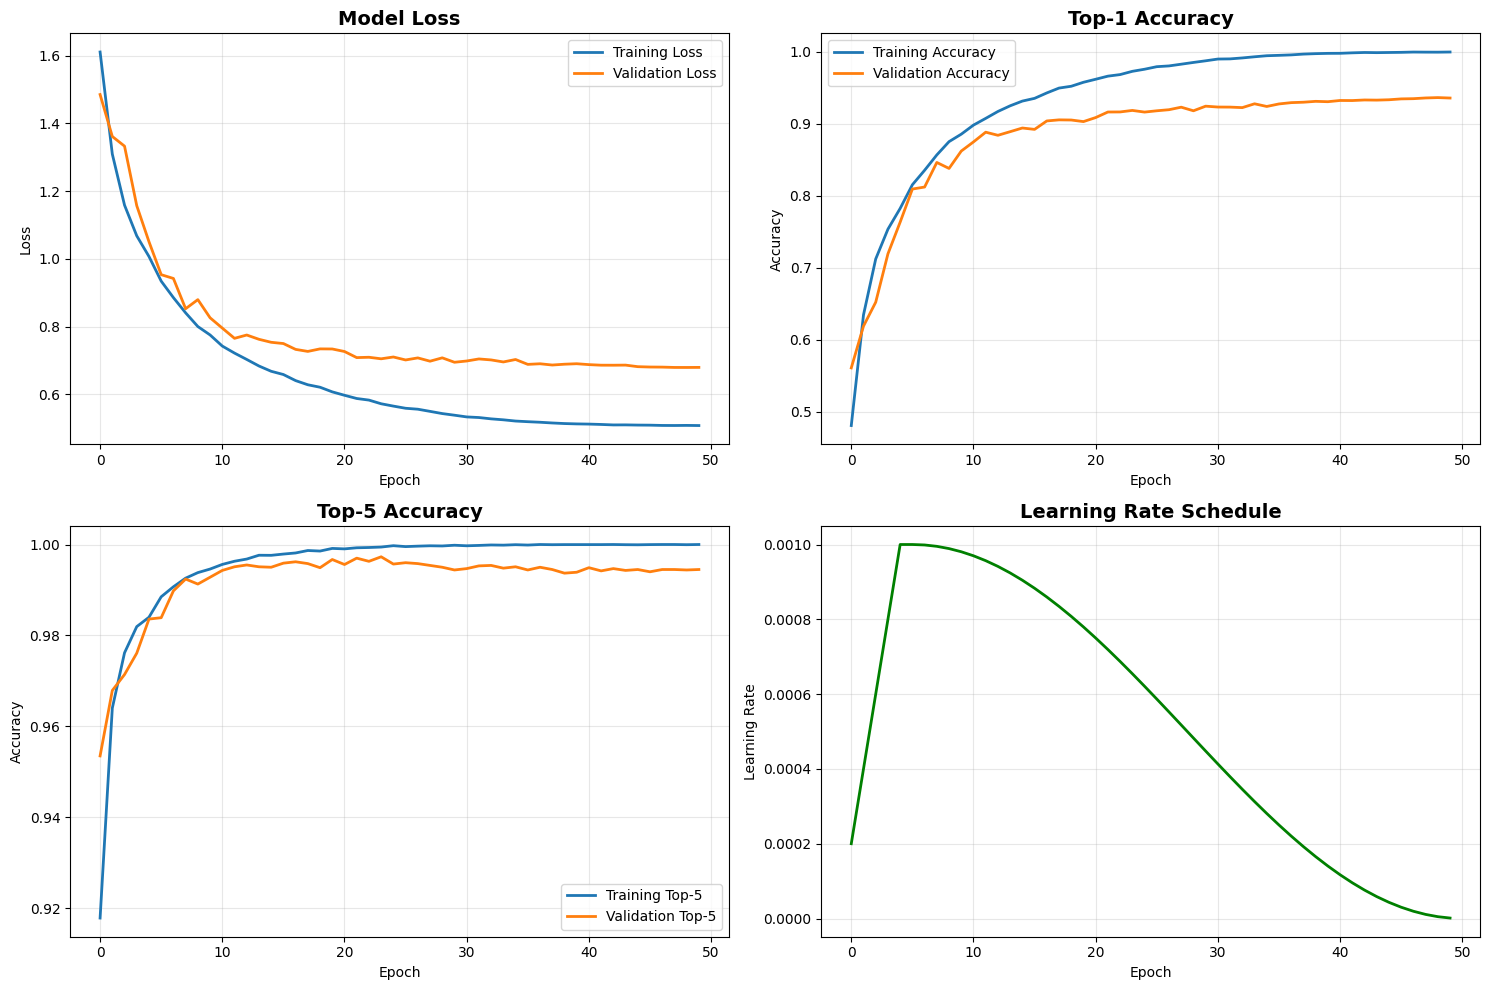

In [7]:
import time

# Label smoothing loss function for older PyTorch versions
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_class = pred.size(1)
        one_hot = torch.zeros_like(pred).scatter(1, target.view(-1, 1), 1)
        one_hot = one_hot * (1 - self.smoothing) + self.smoothing / n_class
        log_prob = torch.nn.functional.log_softmax(pred, dim=1)
        loss = -(one_hot * log_prob).sum(dim=1).mean()
        return loss


def calculate_accuracy(outputs, targets, topk=(1, 5)):
    """Calculate top-k accuracy"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = targets.size(0)

        _, pred = outputs.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(targets.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def run_experiment(model, trainloader, testloader, num_epochs, learning_rate, weight_decay):
    """Train and evaluate the model with all improvements"""

    # Optimizer
    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # Loss function with label smoothing
    criterion = LabelSmoothingCrossEntropy(smoothing=label_smoothing)

    # Learning rate scheduler with warmup
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Linear warmup
            return (epoch + 1) / warmup_epochs
        else:
            # Cosine decay
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            return 0.5 * (1 + np.cos(np.pi * progress))

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # Training history
    history = {
        'loss': [], 'val_loss': [],
        'accuracy': [], 'val_accuracy': [],
        'top5_accuracy': [], 'val_top5_accuracy': [],
        'lr': []
    }

    best_val_acc = 0.0
    best_model_path = './best_model.pth'

    print("Starting training...")
    print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12} {'Val Top-5':<12} {'LR':<10} {'Time':<8}")
    print("-" * 94)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        top5_correct = 0
        total_samples = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            top1_acc, top5_acc = calculate_accuracy(outputs, labels, topk=(1, 5))
            correct_predictions += top1_acc.item() * inputs.size(0) / 100
            top5_correct += top5_acc.item() * inputs.size(0) / 100
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        epoch_top5_acc = top5_correct / total_samples

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_top5_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                top1_acc, top5_acc = calculate_accuracy(outputs, labels, topk=(1, 5))
                val_correct += top1_acc.item() * inputs.size(0) / 100
                val_top5_correct += top5_acc.item() * inputs.size(0) / 100
                val_total += labels.size(0)

        val_epoch_loss = val_loss / val_total
        val_epoch_accuracy = val_correct / val_total
        val_epoch_top5_acc = val_top5_correct / val_total

        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()

        # Save history
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_accuracy)
        history['top5_accuracy'].append(epoch_top5_acc)
        history['val_loss'].append(val_epoch_loss)
        history['val_accuracy'].append(val_epoch_accuracy)
        history['val_top5_accuracy'].append(val_epoch_top5_acc)
        history['lr'].append(current_lr)

        # Save best model
        if val_epoch_accuracy > best_val_acc:
            best_val_acc = val_epoch_accuracy
            torch.save(model.state_dict(), best_model_path)

        # Print progress
        epoch_time = time.time() - epoch_start_time
        print(f"{epoch+1:<6} {epoch_loss:<12.4f} {epoch_accuracy:<12.4f} {val_epoch_loss:<12.4f} "
              f"{val_epoch_accuracy:<12.4f} {val_epoch_top5_acc:<12.4f} {current_lr:<10.6f} {epoch_time:<8.1f}s")

    # Load best model
    model.load_state_dict(torch.load(best_model_path))

    # Final evaluation on test set
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_top5_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            top1_acc, top5_acc = calculate_accuracy(outputs, labels, topk=(1, 5))
            test_correct += top1_acc.item() * inputs.size(0) / 100
            test_top5_correct += top5_acc.item() * inputs.size(0) / 100
            test_total += labels.size(0)

    test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_top5_accuracy = test_top5_correct / test_total

    print("\n" + "="*94)
    print(f"Final Test Results (Best Model):")
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test top-5 accuracy: {test_top5_accuracy * 100:.2f}%")
    print(f"Test loss: {test_loss:.4f}")
    print("="*94)

    return history


# Create and train the model
cnn_classifier = CNNClassifier(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

# Print model summary
print("\nModel Architecture:")
print(cnn_classifier)
print(f"\nTotal parameters: {sum(p.numel() for p in cnn_classifier.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad):,}\n")

# Train the model
history = run_experiment(cnn_classifier, trainloader, testloader, num_epochs, learning_rate, weight_decay)


def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(history['loss'], label='Training Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot top-1 accuracy
    axes[0, 1].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Top-1 Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot top-5 accuracy
    axes[1, 0].plot(history['top5_accuracy'], label='Training Top-5', linewidth=2)
    axes[1, 0].plot(history['val_top5_accuracy'], label='Validation Top-5', linewidth=2)
    axes[1, 0].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot learning rate
    axes[1, 1].plot(history['lr'], linewidth=2, color='green')
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)
